# Project 4: Cd-Aufnahme über die Nahrung bei Folsomia

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pal = sns.color_palette()
from scipy import stats
import pandas as pd
from copy import deepcopy
import pprint
pp = pprint.PrettyPrinter(indent=2)
import os
import pyarrow

current_dir = os.path.dirname(os.path.abspath(''))
project_directory = os.path.dirname(current_dir)

# automatische aktualisierung externer Python-Dateien
%load_ext autoreload
%autoreload 2 

# Einbindung zusätzlicher Funktionen 
from utils import * 
from ModelFitting import *

In [2]:
from mempyDEB.DEBODE.simulators import *
from mempyDEB.DEBODE.defaultparams import *

## Start by fitting the model to control data

In [6]:
from DEBfitting_Folsomia import *
data = load_data()
data.head()

,t_day,length_mm,C_F,T_cels,S
85,0,0.609,0,20,1.420620
86,2,0.723,0,20,1.999511
87,4,0.857,0,20,2.805551
88,7,1.019,0,20,3.960986
89,9,1.095,0,20,4.571232


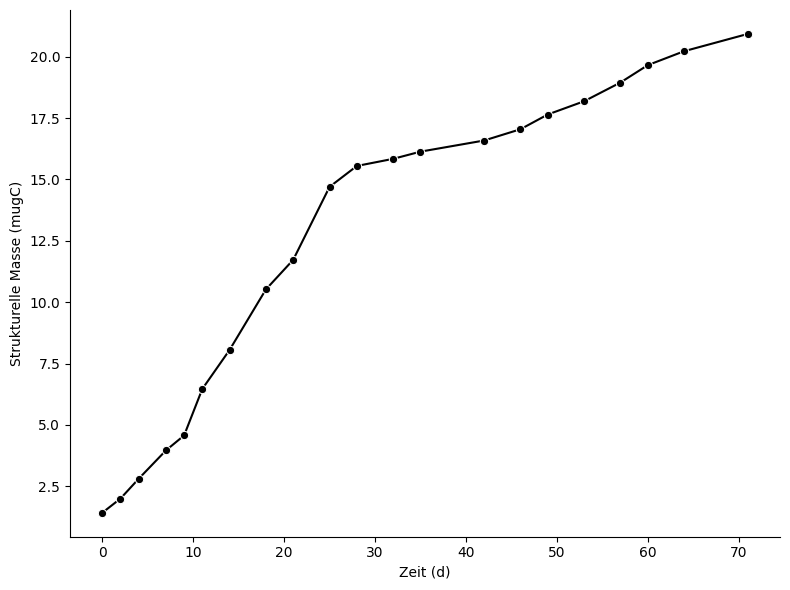

In [7]:
_ = plot_data(data)

c:\Users\Felix\projects\mem25\project\mempyDEB\folsomia_project\DEBfitting_Folsomia.py:89: RuntimeWarning: invalid value encountered in scalar power
  p.spc['Idot_max_rel_emb'] *= zoom_factor_theta**(1/3)


Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'Idot_max_rel': np.float64(4.5482062001716725), 'eta_AS_0': np.float64(0.4064455981275471)}


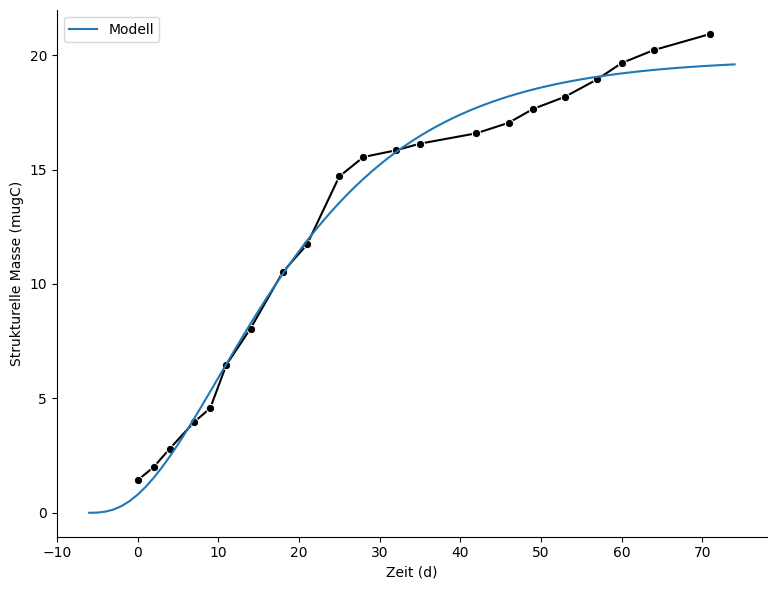

In [11]:
f = fit_model()

c:\Users\Felix\projects\mem25\project\mempyDEB\folsomia_project\DEBfitting_Folsomia.py:89: RuntimeWarning: invalid value encountered in scalar power
  p.spc['Idot_max_rel_emb'] *= zoom_factor_theta**(1/3)


Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'Idot_max_rel': np.float64(4.5482062001716725), 'eta_AS_0': np.float64(0.4064455981275471)}


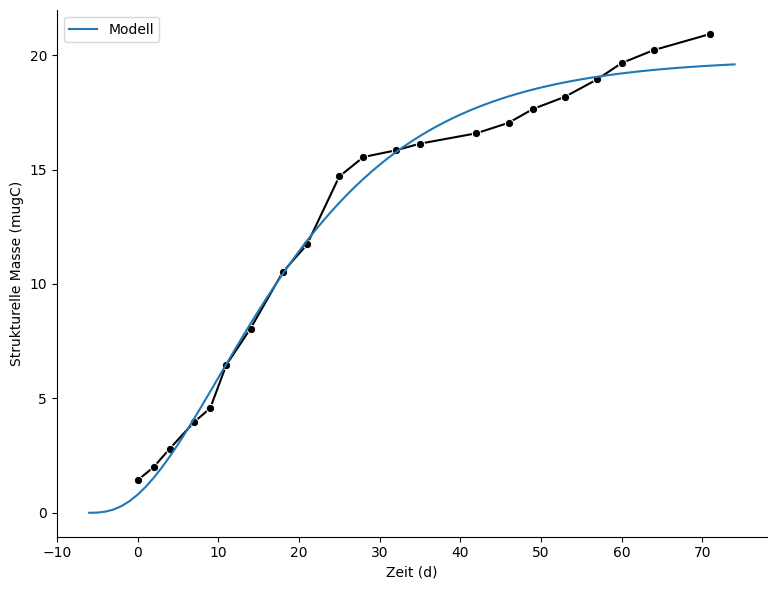

In [21]:
def fit_model_2params():
    """
    DEB-Modellkalibrierung mit zwei Parametern.
    """

    # Definition des ModelFit - Objektes wie zuvor
    f = setup_modelfit() 
    
    # wir müssen hier lediglich den initial guess anpassen
    f.intguess = { 
        'Idot_max_rel' : f.defaultparams.spc['Idot_max_rel'], 
        'eta_AS_0' : f.defaultparams.spc['eta_AS_0']
    }

    # am restlichen Code ändert sich ersmtal nichts

    f.run_optimization()

    print(f"Estimated parameter values: {f.p_opt}")

    # simulate optimized parameters, 

    p = deepcopy(f.defaultparams)
    p.spc.update(f.p_opt)  

    sim_opt = f.simulator(p.spc)

    # plot data + retrodiction

    fig, ax = plot_data(f.data)

    sns.lineplot(sim_opt, x = 't_day', y = 'S', ax = ax, label = "Modell")
    #sns.lineplot(sim_opt, x = 't_day', y = 'cum_repro', ax = ax[1])

    #ax[1].legend()

    return f
 
f_2params = fit_model_2params()

control_fitted_params = f_2params.p_opt


Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'Idot_max_rel': np.float64(22.16813248911843), 'kappa': np.float64(0.17974817617858652), 'eta_AS_0': np.float64(0.6208966943338722), 'S_p': np.float64(88.53348458980821)}


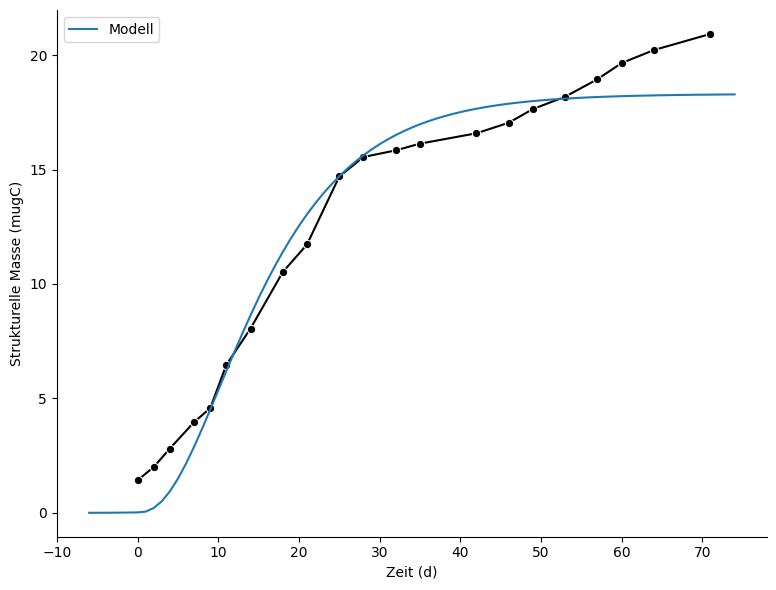

In [22]:
def define_simulator_4params(f: ModelFit):

    """
    Definition der Simulator-Funktion für DEB-Kalibrierung mit drei Parametern.
    """

    def simulator(theta: dict) -> tuple: # theta = rand(priors)

        p = deepcopy(f.defaultparams)
        p.spc.update(theta) 

        S_max_theta = calc_S_max(p.spc) # implizierte maximale Struktur auf basis von theta
        zoom_factor_theta = S_max_theta / S_MAX_REFERENCE # zoom factor auf basis von theta
        
        # diese Parameter skalieren mit der neuen maximalen Größe

        p.spc['Idot_max_rel_emb'] *= zoom_factor_theta**(1/3)
        p.spc['X_emb_int'] *= zoom_factor_theta
        #p.spc['S_p'] *= zoom_factor_theta
        
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            prediction = simulate_DEBBase(p).assign(
                cum_repro = lambda df : np.trunc(df.R / p.spc['X_emb_int']).shift(EMB_DEV_TIME, fill_value = 0)
                ).rename({'t' : 't_day'}, axis = 1)

            return prediction
        
    return simulator

def fit_model_4params():
    """
    DEB-Modellkalibrierung mit 4 Parametern.
    """

    # Definition des ModelFit - Objektes wie zuvor
    
    f = setup_modelfit() 
    
    f.simulator = define_simulator_4params(f)

    f.intguess = { 
        'Idot_max_rel' : f.defaultparams.spc['Idot_max_rel'], 
        'kappa' : f.defaultparams.spc['kappa'],
        'eta_AS_0' : f.defaultparams.spc['eta_AS_0'],
        'S_p' : 100. # geschätzter Anfangswert auf Basis der Abbildung
    }

    f.run_optimization()

    print(f"Estimated parameter values: {f.p_opt}")

    # simulate optimized parameters, 

    p = deepcopy(f.defaultparams)
    p.spc.update(f.p_opt)  

    sim_opt = f.simulator(p.spc)

    # plot data + retrodiction

    fig, ax = plot_data(f.data)

    sns.lineplot(sim_opt, x = 't_day', y = 'S', ax = ax, label = "Modell")
    #sns.lineplot(sim_opt, x = 't_day', y = 'cum_repro', ax = ax[1])

    ax.legend()

    return f
 
f_4params = fit_model_4params()

control_fitted_params = f_4params.p_opt



In [18]:
control_fitted_params

{'Idot_max_rel': np.float64(4.5482062001716725),
 'eta_AS_0': np.float64(0.4064455981275471)}

## use control fit to fit TKTD model

## trying out different PMoA

## fitting different levels of Cd-exposition from food ingestion/assimilation